In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from kedro.extras.datasets.pickle import PickleDataSet
from kedro.config import ConfigLoader

import os, sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src/'))

from src.tagseg.data.acdc_dataset import AcdcDataSet
from src.tagseg.data.dmd_dataset import DmdDataSet, DmdTimeDataSet
from src.tagseg.pipelines.data_splitting.nodes import split_data

In [3]:
conf_paths = ["../conf/base", "../conf/local"]
conf_loader = ConfigLoader(conf_paths)
conf_catalog = conf_loader.get("catalog*", "catalog*/**")

In [4]:
dataset = PickleDataSet(filepath='../data/05_model_input/model_input.pt').load()

In [5]:
loader_dict = split_data(dataset, data_params=dict(train_val_split=.75, batch_size=16))

Loading dataset: 100%|██████████| 940/940 [00:02<00:00, 409.41it/s]


In [6]:
loader_train = loader_dict.get('loader_train')

In [8]:
image = next(iter(loader_train))

/opt/conda/envs/tagroi/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
images, labels = image['image'], image['label'].long()

In [11]:
images.shape

torch.Size([64, 1, 256, 256])

In [23]:
labels.shape

torch.Size([64, 1, 256, 256])

In [46]:
from monai.metrics import DiceMetric, HausdorffDistanceMetric

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
hd_metric = HausdorffDistanceMetric(include_background=False)

In [43]:
from monai.transforms import AsDiscrete, EnsureType, Compose

post_label = Compose([
    EnsureType("tensor", device="cpu"),
    AsDiscrete(to_onehot=2)
])

In [49]:
test_target.shape, test_pred.shape

(torch.Size([2, 1, 256, 256]), torch.Size([2, 1, 256, 256]))

In [53]:
from monai.data import decollate_batch

list(map(lambda x: x.shape, decollate_batch(test_target)))

[torch.Size([1, 256, 256]), torch.Size([1, 256, 256])]

In [50]:
test_target = post_label(labels[38:40])
test_pred = post_label(labels[36:38])

dice_metric(y_pred=test_pred, y=test_target)
hd_metric(y_pred=test_pred, y=test_target)

0.0

RuntimeError: applying transform <monai.transforms.post.array.AsDiscrete object at 0x7fcf212d1fd0>

In [45]:
dice_metric.aggregate(), hd_metric.aggregate()

(tensor([0.4981]), tensor([42.1545], dtype=torch.float64))

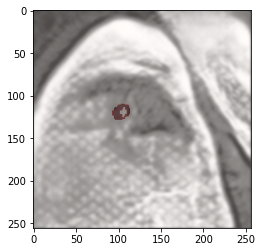

In [28]:
plt.imshow(images[38, 0], cmap='gray')
plt.imshow(labels[38, 0], cmap='Reds', alpha=0.3)